Load Data with Dataset:

In [ ]:
import os
import glob
from PIL import Image
from torch.utils import data

class CovidDataset(data.Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.data = []
        self.target = []

        for path in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/COVID/*"):
            self.data.append(path)
            self.target.append(1)

        for path in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/non-COVID/*"):
            self.data.append(path)
            self.target.append(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        label = self.target[idx]

        image = Image.open(path).convert(mode="RGB")

        
        if self.transform:
            image = self.transform(image)

        return image, label

Check Gpu is available or not :

In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set Transforms for data:

In [ ]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])



Run Dataset loader :

In [ ]:
dataset = CovidDataset(transform=data_transforms)

Number of Data :

In [ ]:
len(dataset)

2481

Print some data randomly :

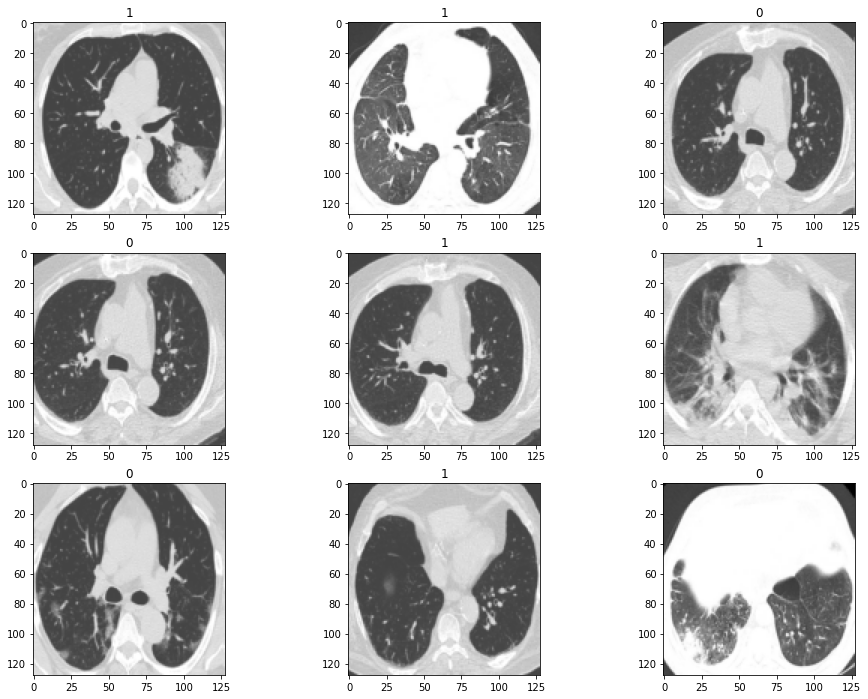

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.randint(len(dataset), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
n = 0
for idx, ax in enumerate(axes.ravel()):
    img = transforms.ToPILImage()(dataset[n][0])
    ax.set_title(dataset[random_idx[n]][1])
    ax.imshow(img)
    n +=1


Split TrainSet and TestSet :

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Size of each one :

In [ ]:
print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(test_dataset)}")

Train Data: 1984
Test Data: 497


Use Data Loader to load data with batch size 32 :

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)


Define our Model 

use pretraned resnet18 model with 1 output classifier

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch import Tensor
import torch.optim as optim

class CovidModel(nn.Module):
    def __init__(self, pretrained: bool = True):
        super(CovidModel, self).__init__()
        resnet_model = models.resnet18(pretrained=pretrained)
        resnet_modules = list(resnet_model.children())
        self.model = nn.Sequential(*resnet_modules[:-1]) 
        self.classifier = nn.Linear(resnet_modules[-1].in_features, 1)

    def forward(self, x: Tensor) -> Tensor:
        batch_size = x.size()[0]
        x = self.model(x)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        x = torch.sigmoid(x).squeeze(1)
        return x

Set Optimizer and build model :

In [ ]:
model = CovidModel(pretrained=True).to(device)
    # define optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=0)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reset Parametrs model befor train :

In [ ]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

Train the Model :

In [ ]:
import numpy as np
# Define the loss
criterion = nn.BCELoss

epochs = 25
train_losses = np.zeros(epochs)

for e in range(epochs):
    
    train_loss = []
    for inputs, labels in trainloader:    
        labels = labels.to(torch.float32)
        inputs , labels = inputs.to(device) , labels.to(device)

        # Training pass

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion()(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    train_losses[e] = train_loss

    print(f'Epoch {e+1}/{epochs} , Train Loss: {train_loss:.4f}')


print('Finished Training')

Epoch 1/25 , Train Loss: 0.0895
Epoch 2/25 , Train Loss: 0.0367
Epoch 3/25 , Train Loss: 0.0501
Epoch 4/25 , Train Loss: 0.0219
Epoch 5/25 , Train Loss: 0.0377
Epoch 6/25 , Train Loss: 0.0334
Epoch 7/25 , Train Loss: 0.0106
Epoch 8/25 , Train Loss: 0.0040
Epoch 9/25 , Train Loss: 0.0008
Epoch 10/25 , Train Loss: 0.0029
Epoch 11/25 , Train Loss: 0.0019
Epoch 12/25 , Train Loss: 0.0006
Epoch 13/25 , Train Loss: 0.0004
Epoch 14/25 , Train Loss: 0.0006
Epoch 15/25 , Train Loss: 0.0005
Epoch 16/25 , Train Loss: 0.0003
Epoch 17/25 , Train Loss: 0.0002
Epoch 18/25 , Train Loss: 0.0002
Epoch 19/25 , Train Loss: 0.0003
Epoch 20/25 , Train Loss: 0.0003
Epoch 21/25 , Train Loss: 0.0002
Epoch 22/25 , Train Loss: 0.0001
Epoch 23/25 , Train Loss: 0.0001
Epoch 24/25 , Train Loss: 0.0001
Epoch 25/25 , Train Loss: 0.0001
Finished Training


Check Acc Model :

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)     
            scores = model(x)
            # print(scores)
            predicted = np.where(scores.cpu() > 0.5, 1, 0)
            print(predicted)
            print(y)
            num_correct += np.sum(np.equal(predicted, y.cpu().detach().numpy()).astype(float))
            num_samples += len(predicted)        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

check_accuracy(testloader,model)

[1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1]
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
[0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0]
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
[1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0]
tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
[1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0]
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
[1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1]
tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
[1 0 1 1 1 1 1 0 0 0

Check output model for one of image :

In [ ]:
with torch.no_grad():
    tempImage = Image.open("/content/drive/MyDrive/Colab Notebooks/data/non-COVID/Non-Covid (1000).png").convert(mode="RGB")
    # print(tempImage)
    tempImage = data_transforms(tempImage)
    # print(tempImage)
    tempImage = tempImage.unsqueeze(0)
    tempImage = tempImage.to(device=device) 
    scores = model(tempImage)
    print(scores)

tensor([0.3034], device='cuda:0')
